[Open in Colab](https://colab.research.google.com/github/LapTQ/deep_spray/blob/main/notebook.ipynb)

In [1]:
# !git clone https://github.com/getchar49/deepspray.git

In [ ]:
# !git clone https://github.com/LapTQ/deep_spray.git
# %cd deep_spray

In [2]:
class_name = ['bag', 'lobe', 'Detached ligament', 'drop', 'Attached ligament']
colors = ['red', 'orange', 'deepskyblue', 'mediumseagreen', 'darkgoldenrod']

name_to_id_mapping = {name: id for id, name in enumerate(class_name)}
id_to_name_mapping = {id: name for id, name in enumerate(class_name)}
name_to_color_mapping = {name: color for name, color in zip(class_name, colors)}
id_to_color_mapping = {id: color for id, color in enumerate(colors)}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import cv2
import os
from utils.dataset import *

In [4]:
# ### VISUALIZE
#
# for lbl_path in Path('data/labeled/labels').glob('*'):
#     lbl_path = str(lbl_path)
#     img_path = lbl_path.replace('labels', 'images').replace('txt', 'png')
#
#     boxes = process_txt(lbl_path)
#     boxes = np.array([box[1:] + box[:1] for box in boxes])
#     img = Image.open(img_path).convert('RGB')
#     img = np.array(img)
#     boxes = yolo_to_coco(img.shape[:2], boxes)
#     boxes = xywh_to_xyxy(boxes)
#     print(lbl_path)
#     plt.figure(figsize=(40, 20))
#     plot_image(img, boxes=boxes, id_to_color_mapping=id_to_color_mapping, id_to_name_mapping=id_to_name_mapping)
#     plt.show()          # uncomment this to show images
#
# ### END

In [5]:
# lbl_path = 'deepspray/data/data_1/labels/f_01495.txt'
# img_path = lbl_path.replace('labels', 'images').replace('txt', 'png')
#
# img = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
# # thử paste ra ảnh trắng cùng kích thước
# out_img = np.full_like(img, 255)
#
# boxes = process_txt(lbl_path)
# boxes = [box[1:] for box in boxes]
# boxes = xywh_to_xyxy(yolo_to_coco(img.shape, boxes))
#
# for box in boxes:   # box: [class_id, x, y, w, h]
#     x1, y1, x2, y2 = box
#     out_img[y1:y2, x1:x2] = img[y1:y2, x1:x2]
#
# plt.figure(figsize=(40, 20))
# plt.imshow(out_img)
# plt.show()

In [6]:
# # augment đơn giản:
# # dùng các box đã đánh nhãn thủ công (vẫn giữ background xung quanh, - xử lý sau), và dòng chính (vẫn giữ lại các giọt chưa gán nhãn - xử lí sau :D)
# # đổi vị trí cho nhau
# # thay đổi kích thước, nhưng trong giới hạn cho phép (cụ thể chưa biết)
#
# img = np.array(Image.open(img_path).convert('RGB'))
#
# boxes = process_txt(lbl_path)
# boxes = [box[1:] + box[:1] for box in boxes]
# boxes = xywh_to_xyxy(yolo_to_coco(img.shape, boxes))
#
# plt.figure(figsize=(40, 20))
# plot_image(img, boxes=boxes, id_to_color_mapping=id_to_color_mapping, id_to_name_mapping=id_to_name_mapping)
# plt.show()
#
# # # paste vào ảnh trắng
# # des_img = np.full_like(img, 255)
# # des_img, des_boxes = augment(img, boxes, des_img, None)
#
# # paste vào chính ảnh gốc (thay đổi vị trí các giọt)
# des_img = wipe(img, boxes)
# des_img, des_boxes = augment(img, boxes, des_img, None)
# plt.figure(figsize=(40, 20))
# plot_image(des_img, boxes=des_boxes, id_to_name_mapping=id_to_name_mapping, id_to_color_mapping=id_to_color_mapping)
# plt.show()

# Bắt đầu

In [7]:
# 2.2.1. Contour > Đưa về ảnh nhị phân
os.makedirs('1', exist_ok=True)

img_path = 'data/unlabeled/f_01572.png'

img = cv2.imread(img_path)
cv2.imwrite('1/img.png', img)

# chuyển ảnh về gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite('1/img_gray.png', img_gray)

# tạo mask chỉ lấy vật thể
img_mask = np.full_like(img_gray, 255)
img_mask[np.where(img_gray == 255)] = 0
cv2.imwrite('1/img_mask.png', img_mask)

# # global threshold: README
# ret, thresh = cv2.threshold(img_gray, 180, 255, cv2.THRESH_BINARY_INV)
# cv2.imwrite('1/thresh.png', thresh)

True

In [8]:
# # Hướng 1: dùng CLAHE trên ảnh (BỎOOOOOOOOOOOOOOOOOOOOOO)
#
# ### tham số cần chỉnh
# clipLimit = 40.0
# nrow, ncol = (50, 50)
#
# clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(nrow, ncol))
#
# img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
# img_hls[:, :, 1] = clahe.apply(img_hls[:, :, 1])
# img_clahe = cv2.cvtColor(img_hls, cv2.COLOR_HLS2BGR)
# cv2.imwrite('1/img_clahe.png', img_clahe)
#
# img_clahe_gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
# cv2.imwrite('1/img_clahe_gray.png', img_clahe_gray)
#
# tileH, tileW = img.shape[0] // nrow, img.shape[1] // ncol
# max_plot = 0
# for i in range(4, nrow):
#     j = i + 3
#     patch = img_gray[tileH * i: tileH * (i + 1), tileW * j: tileW * (j + 1)]
#     patch_clahe = img_clahe_gray[tileH * i: tileH * (i + 1), tileW * j: tileW * (j + 1)]
#     plt.figure(figsize=(20, 5))
#     plt.subplot(1, 4, 1); plt.imshow(patch, cmap='gray')
#     plt.subplot(1, 4, 2); plt.imshow(patch_clahe, cmap='gray')
#     plt.subplot(1, 4, 3); plt.hist(patch.ravel(), 256, [0, 256])
#     plt.subplot(1, 4, 4); plt.hist(patch_clahe.ravel(), 256, [0, 256])
#     plt.show()
#     max_plot += 1
#     if max_plot == 14:
#         break


In [9]:
# # Hướng 2: Dùng CLAHE, nhưng chỉ áp dụng cho phần màu xanh (dùng mask, có thể dilate) => hình cho ra tệ quá (BỎOOOOOOOOOOOOOOOOOOOOOO)
#
# ### tham số cần chỉnh
# nrow, ncol = (120, 160)
#
# img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
#
# tileH, tileW = img.shape[0] // nrow, img.shape[1] // ncol
# max_plot = 0
# for i in range(nrow):
#     for j in range(ncol):
#         patch = img_gray[tileH * i: tileH * (i + 1), tileW * j: tileW * (j + 1)]
#         patch_mask = img_mask[tileH * i: tileH * (i + 1), tileW * j: tileW * (j + 1)]
#         kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#         patch_mask = cv2.dilate(patch_mask, kernel, iterations=1)
#
#         loc = np.where(patch_mask == 255)
#         if loc[0].shape[0] < 24:
#             val = patch[loc]
#             val = cv2.equalizeHist(val)
#             patch_he = patch.copy()
#             for k, l in enumerate(zip(loc[0], loc[1])):
#                 patch_he[l[0], l[1]] = val[k][0]
#
#             img_hls[tileH * i: tileH * (i + 1), tileW * j: tileW * (j + 1), 1] = patch_he
#
#             ### CHỈ ĐỂ VISUALIZE
#             if loc[0].shape[0] > 0 and max_plot < 14:
#                 if j == i + 3:
#                     plt.figure(figsize=(20, 5))
#                     plt.subplot(1, 4, 1); plt.imshow(patch, cmap='gray')
#                     plt.subplot(1, 4, 2); plt.imshow(patch_he, cmap='gray')
#                     plt.subplot(1, 4, 3); plt.hist(patch[loc], 256, [0, 256])
#                     plt.subplot(1, 4, 4); plt.hist(patch_he[loc], 256, [0, 256])
#                     plt.show()
#                     max_plot += 1
#             ### HẾT
#
# img_clahe = cv2.cvtColor(img_hls, cv2.COLOR_HLS2BGR)
# cv2.imwrite('1/img_clahe.png', img_clahe)
#
# img_clahe_gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
# cv2.imwrite('1/img_clahe_gray.png', img_clahe_gray)

In [10]:
# # Hướng 3: Không dùng CLAHE nữa, mà equalizeHist trên thành phần liên thông (BỎOOOOOOOOOOOOOOOOOOOOOO)
#
# nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_mask, connectivity=4)
# img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
# for k in range(1, nLabels):
#     loc = np.where(labels == k)
#     val = img_gray[loc]
#     val = cv2.equalizeHist(val)
#     for i, l in enumerate(zip(loc[0], loc[1])):
#         img_hls[l[0], l[1], 1] = val[i][0]
#
# img_he = cv2.cvtColor(img_hls, cv2.COLOR_HLS2BGR)
# cv2.imwrite('1/img_he.png', img_he)
#
# img_he_gray = cv2.cvtColor(img_he, cv2.COLOR_BGR2GRAY)
# cv2.imwrite('1/img_he_gray.png', img_he_gray)
#
# temp = []
# for thresh in range(240, 256):
#     img_he_mask = np.full_like(img_he_gray, 255)
#     img_he_mask[np.where(img_he_gray >= thresh)] = 0
#     nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_he_mask, connectivity=4)
#     temp.append(nLabels)
#     cv2.imwrite(f'1/img_he_mask{thresh}.png', img_he_mask)
# plt.plot(temp)
# plt.show()


## Lọc lấy giọt bé

In [11]:
# Hướng 4: Không dùng CLAHE hay HE vội nữa, mà lọc lấy giọt bé bằng thành phần liên thông luôn (OK)

uimg_path = 'data/unlabeled/f_01572.png'

uimg = cv2.imread(uimg_path)
uimg_gray = cv2.cvtColor(uimg, cv2.COLOR_BGR2GRAY)
uimg_mask = np.full_like(uimg_gray, 255)
uimg_mask[np.where(uimg_gray == 255)] = 0

uimg_orig = uimg.copy()

# mục tiêu: dọn dẹp để sinh dữ liệu cho DL:
# giả sử kích thước của cc trải dài:
# ****************************
# -----------                         A phần mà CV bắt được
#       ----------------------        B phần mà DL sẽ huấn luyện trên nó
#      60
# A ^ B là phần giọt mà DL có thể bắt được, và CÓ THỂ sẽ chỉ dùng CV để bắt để phục vụ cho quá trình sinh dữ liệu (trường hợp nó dính nhau mà CV ko thể nhận biết được) cho DL, sau khi DL train xong thì CÓ THỂ sẽ tin tưởng DL hơn. CV khi lọc để sinh thì không cần bắt hết, Precision >> Recall
# A - (A ^ B): phần mà DL chắc chắn không bắt được
#

########### hình như dùng cc thì không bị nối đỉnh như contour thì phải => làm thí nghiệm xem sao :)))
#           tuy nhiên vẫn có lỗi ở trường hợp 2 giọt 2x2 nối với nhau theo đúng 1 cạnh

# Tìm thành phần liên thông trên mask
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(uimg_mask, connectivity=4)

YELLOW = (0, 195, 255)
RED = (51, 87, 255)
GREEN = (50, 205, 50)
BLUE = (255, 249, 126)
PURPLE = (255, 0, 170)

# Lưu lại box của các drop, tạo mask mới cho những thứ còn lại
points = []
class_name = []
centers = []
src_img = []

### chỉ để visualize
vis_box = uimg.copy()
vis_seg = cv2.cvtColor(uimg_mask, cv2.COLOR_GRAY2BGR); vis_seg[uimg_mask == 255] = RED
###

for k in range(1, retval):
    size = stats[k, cv2.CC_STAT_AREA]
    if size < 60:
        loc = np.roll(np.where(labels == k), 1, axis=0).transpose().reshape(-1, 2)
        points.append(np.where(labels == k))
        class_name.append('small drop')
        centers.append(centroids[k])
        src_img.append(uimg_orig)

        # sau khi đánh nhãn xong thì xóa đi
        uimg[labels == k] = 255
        uimg_gray[labels == k] = 255
        uimg_mask[labels == k] = 0

        ### chỉ để visualize
        xywha = cv2.minAreaRect(loc)
        xyxy = cv2.boxPoints(xywha).astype(np.int32)
        cv2.drawContours(vis_box, [xyxy], -1, GREEN, 1)
        vis_seg[labels == k] = GREEN
        ###

# ### chỉ để visualize
# plt.figure(figsize=(20, 20))
# plt.imshow(cv2.cvtColor(vis_box, cv2.COLOR_BGR2RGB))
# plt.show()
# plt.figure(figsize=(20, 20))
# plt.imshow(cv2.cvtColor(vis_seg, cv2.COLOR_BGR2RGB))
# plt.show()
# ###

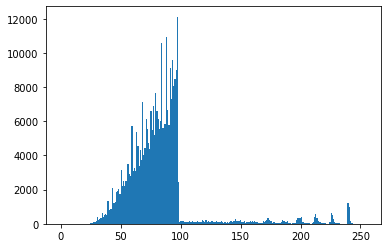

In [12]:
# Loại bỏ viền trước khi lọc tiếp => Hay, phải đem ra
# hỏi thầy xem có cách nào tự động tìm ra điểm này không?

plt.hist(uimg_gray.ravel(), 255, [0, 254])
plt.show()
loc = np.where(uimg_gray > 100)

uimg[loc] = 255
uimg_gray[loc] = 255
uimg_mask[loc] = 0

In [13]:
# Lọc tiếp lần nữa, y hệt bước trên, do sau khi bỏ viền sẽ có một số giọt tách ra

retval, labels, stats, centroids = cv2.connectedComponentsWithStats(uimg_mask, connectivity=4)

for k in range(1, retval):
    size = stats[k, cv2.CC_STAT_AREA]
    if size < 60:
        loc = np.roll(np.where(labels == k), 1, axis=0).transpose().reshape(-1, 2)
        points.append(np.where(labels == k))
        class_name.append('small drop')
        centers.append(centroids[k])
        src_img.append(uimg_orig)

        # sau khi đánh nhãn xong thì xóa đi
        uimg[labels == k] = 255
        uimg_gray[labels == k] = 255
        uimg_mask[labels == k] = 0

        ### chỉ để visualize
        xywha = cv2.minAreaRect(loc)
        xyxy = cv2.boxPoints(xywha).astype(np.int32)
        cv2.drawContours(vis_box, [xyxy], -1, GREEN, 1)
        vis_seg[labels == k] = GREEN
        ###


# ### chỉ để visualize
# plt.figure(figsize=(20, 20))
# plt.imshow(cv2.cvtColor(vis_box, cv2.COLOR_BGR2RGB))
# plt.show()
# plt.figure(figsize=(20, 20))
# plt.imshow(cv2.cvtColor(vis_seg, cv2.COLOR_BGR2RGB))
# plt.show()
# ###

## Lọc lấy giọt to

In [14]:
# lọc lấy phần chung: (BỎOOOOOOOOOOOOOOOOOOOOOO vì không biết phải dùng cái nào cho tốt => phải có kết quả thực nghiệm mới được)
# hướng 1: dùng matchshape


In [15]:
# https://www.geeksforgeeks.org/find-circles-and-ellipses-in-an-image-using-opencv-python/#:~:text=To%20identify%20circles%2C%20ellipses%2C%20or,SimpleBlobDetector()%20function%20of%20OpenCV.

# Hướng 2: dùng blob với các tiêu chí

retval, labels, stats, centroids = cv2.connectedComponentsWithStats(uimg_mask, connectivity=4)

params = cv2.SimpleBlobDetector_Params()

params.filterByArea = False
params.filterByInertia = False

params.filterByCircularity = True
params.minCircularity = 0.8

params.filterByConvexity = True
params.minConvexity = 0.96

detector = cv2.SimpleBlobDetector_create(params)

for k in range(1, retval):
    cc_mask = np.zeros_like(uimg_mask)
    cc_mask[labels == k] = 255

    loc = np.roll(np.where(labels == k), 1, axis=0).transpose().reshape(-1,2)
    keypoints = detector.detect(255 - cc_mask)
    if len(keypoints) == 1:
        points.append(np.where(labels == k))
        class_name.append('large drop')
        centers.append(centroids[k])
        src_img.append(uimg_orig)

        # sau khi đánh nhãn xong thì xóa đi
        uimg[labels == k] = 255
        uimg_gray[labels == k] = 255
        uimg_mask[labels == k] = 0

        ### chỉ để visualize
        xywha = cv2.minAreaRect(loc)
        xyxy = cv2.boxPoints(xywha).astype(np.int32)
        cv2.drawContours(vis_box, [xyxy], -1, YELLOW, 1)
        vis_seg[labels == k] = YELLOW


# ### chỉ để visualize
# plt.figure(figsize=(20, 20))
# plt.imshow(cv2.cvtColor(vis_box, cv2.COLOR_BGR2RGB))
# plt.show()
# plt.figure(figsize=(20, 20))
# plt.imshow(cv2.cvtColor(vis_seg, cv2.COLOR_BGR2RGB))
# plt.show()
# ###

## Lấy ligment từ ảnh đã gán nhãn

In [16]:
for lbl_path in Path('data/labeled/labels').glob('*edit.txt'):

    lbl_path = str(lbl_path) # 'data/labeled/labels/f_01477-edit.txt'
    limg_path = lbl_path.replace('labels', 'images').replace('txt', 'png')

    boxes = process_txt(lbl_path)
    boxes = np.array([box[1:] + box[:1] for box in boxes])
    limg = cv2.imread(limg_path)
    boxes = yolo_to_coco(limg.shape[:2], boxes)
    boxes = xywh_to_xyxy(boxes)

    limg_gray = cv2.cvtColor(limg, cv2.COLOR_BGR2GRAY)
    limg_mask = np.full_like(limg_gray, 255)
    limg_mask[np.where(limg_gray > 125)] = 0

    for box in boxes:
        if int(box[-1]) == 2:   # neu la ligament
            x1, y1, x2, y2 = box[:4]
            x1, y1, x2, y2 = x1 - 4, y1 - 4, x2 + 4, y2 + 4
            cc_mask = np.zeros_like(limg_mask)
            cc_mask[y1:y2, x1:x2] = 255
            cc_mask[np.logical_not(np.logical_and(cc_mask == 255, limg_mask == 255))] = 0
            # cc_mask = cv2.dilate(cc_mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1)

            retval, labels, stats, centroids = cv2.connectedComponentsWithStats(cc_mask, connectivity=4)
            k = sorted([(k, stats[k, cv2.CC_STAT_AREA]) for k in range(1, retval)], key=lambda x: x[1], reverse=True)[0][0]
            cc_mask[labels != k] = 0
            # TODO rat tho xo
            points.append(np.where(cc_mask == 255))
            class_name.append('deattached ligament')
            centers.append(centroids[k])
            src_img.append(limg)

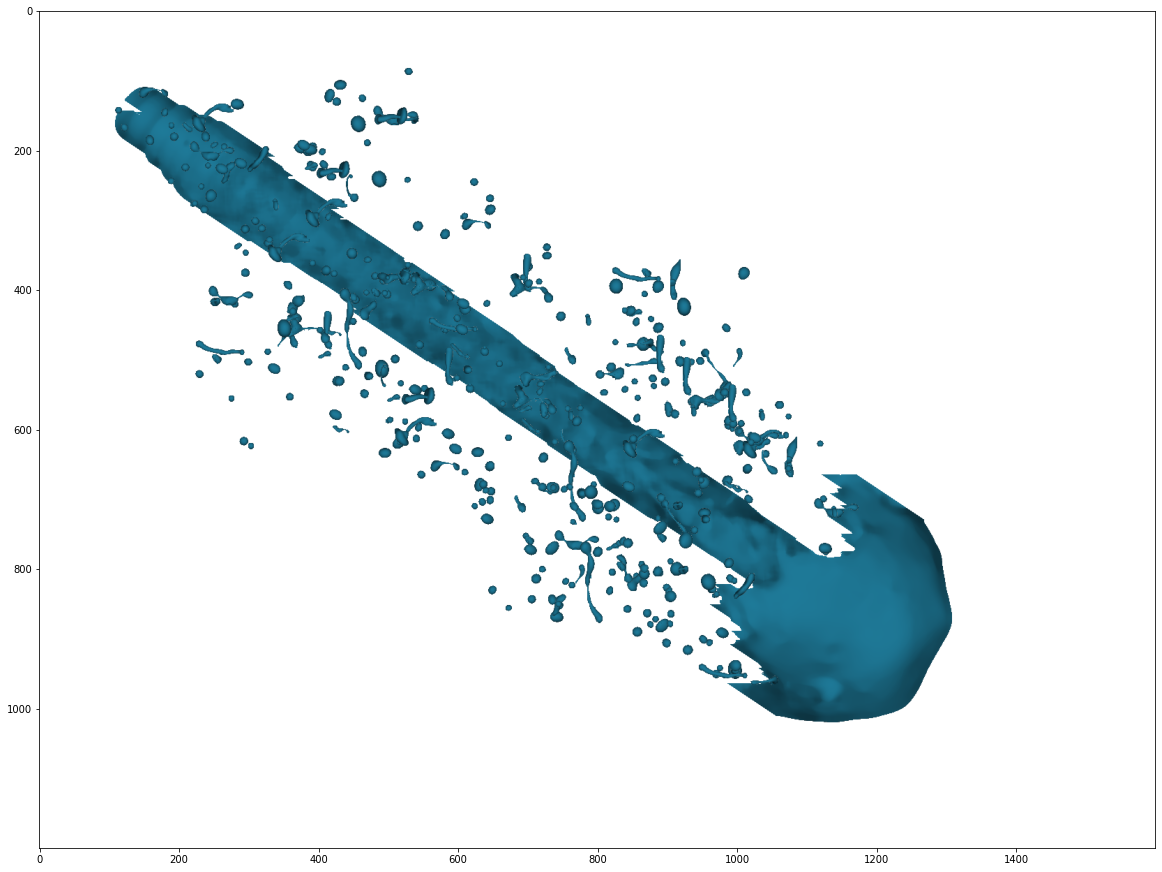

In [17]:
# Lấy ra dòng chính

main = cv2.medianBlur(uimg, ksize=15)

kernel = np.array([
    [1, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 1],
], dtype=np.uint8)

main_mask = cv2.morphologyEx(uimg_mask, cv2.MORPH_OPEN, kernel, iterations=20)

retval, labels, stats, centroids = cv2.connectedComponentsWithStats(main_mask, connectivity=4)
sizes = sorted([(k, stats[k, cv2.CC_STAT_AREA]) for k in range(1, retval)], key=lambda x: x[1], reverse=True)
k_main = sizes[0][0]

main_mask[labels != k_main] = 0
main[labels != k_main] = 255

main_loc = np.where(labels == k_main)


# lấy các vị trí để dán attached ligament



main_mask_edge = main_mask.copy()
main_mask_edge[:800, :1100] = 0
main_mask_edge = cv2.Canny(main_mask_edge, 100, 200)
main_mask_edge[1000:,...] = 0
main_mask_edge[..., 1200:] = 0
main_mask_edge[main_mask_edge > 100] = 255
main_mask_edge = cv2.ximgproc.thinning(main_mask_edge)

x_loc = np.where(main_mask_edge == 255)

# dán giọt
# chưa xét trường hợp dán 2 giọt dè nhau hoàn toàn (bỏ box của những cái đó đi)
# chưa áp dụng các kiểu xoay, zoom, làm méo ligament

n = 400
#####################################
rand_idx = np.random.choice([i for i in range(len(class_name)) if class_name[i] != 'small drop'], n)
rand_centers = (np.array([int(centers[i][0]) for i in rand_idx]),
                np.array([int(centers[i][1]) for i in rand_idx]))



n_in = int(0.24 * n)
n_out = n - n_in
rand_in_idx = np.random.choice([i for i in range(main_loc[0].shape[0]) if main_loc[0][i] < 800 and main_loc[1][i] < 1000], n_in)
rand_out_idx = np.random.choice([i for i in range(len(centers))], n_out)
rand_loc = (np.array([main_loc[0][i] for i in rand_in_idx] + [int(centers[i][1]) for i in rand_out_idx]),
            np.array([main_loc[1][i] for i in rand_in_idx] + [int(centers[i][0]) for i in rand_out_idx]))

syn_boxes = []

for i in range(n):
    syn_pt = (rand_loc[0][i] - rand_centers[0][i] + points[rand_idx[i]][1],
                       rand_loc[1][i] - rand_centers[1][i] + points[rand_idx[i]][0])

    if 'drop' in class_name[rand_idx[i]]:
        main[syn_pt] = src_img[rand_idx[i]][points[rand_idx[i]]]
        class_id = 3
    elif 'ligament' in class_name[rand_idx[i]]:
        main[syn_pt] = src_img[rand_idx[i]][points[rand_idx[i]]]
        class_id = 2

    loc = np.roll(syn_pt, 1, axis=0).transpose().reshape(-1, 2)
    x, y, w, h = cv2.boundingRect(loc)
    syn_boxes.append([x, y, x + w, y + h, class_id])


plt.figure(figsize=(20, 20))
demo = plot_image(cv2.cvtColor(main, cv2.COLOR_BGR2RGB))#, boxes=syn_boxes, id_to_name_mapping=id_to_name_mapping, id_to_color_mapping=id_to_color_mapping)
plt.show()


# Đã cũ

In [47]:
!convert -delay 20 -loop 0 1/demo*.png 1/myimage.gif

In [10]:
contours, hierarchy = cv2.findContours(
    image=thresh,
    mode=cv2.RETR_CCOMP,                        # RETR_LIST: NO relationship, RETR_EXTERNAL: ignores child contours, RETR_CCOMP: 2-level hierarchy
    method=cv2.CHAIN_APPROX_NONE                # CHAIN_APPROX_SIMPLE: compresses line segments and leaves only their end points
)                                               # hierarchy: [Next, Previous, First_Child, Parent]

# lọc chỉ lấy contour của level-1
contours = [contours[i] for i in range(len(contours)) if hierarchy[0][i][-1] == -1]
hierarchy = np.array([[hierarchy[0][i] for i in range(len(hierarchy[0])) if hierarchy[0][i][-1] == -1]])

# vẽ contour lên ảnh thresh
contour_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
cv2.drawContours(
    image=contour_thresh,
    contours=contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=1,
    lineType=cv2.LINE_8
)

cv2.imwrite('1/contour_thresh.png', contour_thresh)


True

In [11]:
# area: 'm00'
# centroid cx: int(M['m10']/M['m00']), cy: int(M['m01']/M['m00'])
moments = [cv2.moments(cnt) for cnt in contours]
areas = [cv2.contourArea(cnt) for cnt in contours]

# the 2nd param specifies whether shape is a closed contour
perimeters = [cv2.arcLength(cnt, True) for cnt in contours]

In [12]:
# trích bounding box theo trục từ contour
# rectangles = [cv2.boundingRect(cnt) for cnt in contours]

# trích bounding box khớp nhất
rectangles = [cv2.minAreaRect(cnt) for cnt in contours]         # [(x, y), (w, h), angle_of_rotate]

# chuyển từ xywh sang xyxy
boxes = [cv2.boxPoints(rect).astype('int32') for rect in rectangles]

# aspect ratio
epsilon = 1
ratios = [np.exp(np.abs(np.log((rect[1][0] + epsilon) / (rect[1][1] + epsilon)))) for rect in rectangles]

thresh_boxes = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
cv2.drawContours(thresh_boxes, boxes, -1, (0, 195, 255), 1, cv2.LINE_4)
cv2.imwrite('1/thresh_boxes.png', thresh_boxes)

True

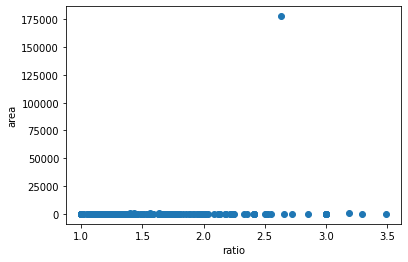

In [13]:
plt.scatter(ratios, areas)
plt.xlabel('ratio')
plt.ylabel('area')
plt.show()

In [14]:
# dùng luật về tỉ lệ và diện tích: README

img_arearatio = img.copy()
cv2.drawContours(img_arearatio, [boxes[i] for i in range(len(boxes)) if ratios[i] < 2.5 or areas[i] < 20], -1, (0, 195, 255), 1, cv2.LINE_4)
cv2.drawContours(img_arearatio, [boxes[i] for i in range(len(boxes)) if 2.5 <= ratios[i] and 20 <= areas[i]], -1, (51, 87, 255), 1, cv2.LINE_4)

cv2.imwrite('1/img_arearatio.png', img_arearatio)

True

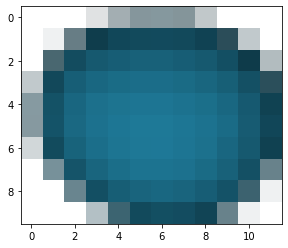

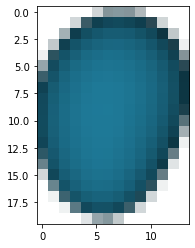

True

In [15]:
# dùng luật về moment (HuMoment, không phải nội dung như SIFT): README

# giot tròn: 1, 11, 12, 13, 19, 27, 34, 39, 44, 46, 50, 52, 59, 84, 94, 98
# giọt dài: 3, 10, 15, 18, 32,
idx_1 = 1
idx_2 = 3

# hiển thị ảnh của template
x1, y1, w, h = cv2.boundingRect(contours[idx_1])
drop = get_drops(img, [[x1, y1, x1 + w, y1 + h]])[0]
plt.imshow(cv2.cvtColor(drop, cv2.COLOR_BGR2RGB))
plt.show()
x1, y1, w, h = cv2.boundingRect(contours[idx_2])
drop = get_drops(img, [[x1, y1, x1 + w, y1 + h]])[0]
plt.imshow(cv2.cvtColor(drop, cv2.COLOR_BGR2RGB))
plt.show()

# tính độ khớp với mỗi template
ret_1 = [cv2.matchShapes(contours[idx_1], cnt, 1, 0.0) for cnt in contours]
ret_2 = [cv2.matchShapes(contours[idx_2], cnt, 1, 0.0) for cnt in contours]
img_matchshape_1 = img.copy()
maskout_1 = np.full_like(img, 255)

YELLOW = (0, 195, 255)
RED = (51, 87, 255)
GREEN = (50, 205, 50)

# mask_red = []
for i in range(len(boxes)):
    # vẽ contour màu vàng cho các drop, đồng thời tạo mask để tí lọc bỏ các drop này
    # có thể đánh nhãn luôn ở bước này
    if ret_1[i] < 0.16 or ret_2[i] < 0.16 or areas[i] < 10:
        cv2.drawContours(img_matchshape_1, [contours[i]], -1, YELLOW, 1, cv2.LINE_4)
        cv2.drawContours(maskout_1, [contours[i]], -1, 0, -1, cv2.LINE_4)
    else:
        # vẽ contour màu đỏ cho các trường hợp còn lại
        cv2.drawContours(img_matchshape_1, [contours[i]], -1, RED, 1, cv2.LINE_4)

        # # tạo riêng từng mask cho mỗi contour đó
        # tmask = np.zeros_like(img)
        # cv2.drawContours(tmask, [contours[i]], -1, (255, 255, 255), -1, cv2.LINE_4)
        # mask_red.append(tmask)


cv2.imwrite('1/img_matchshape_1.png', img_matchshape_1)
cv2.imwrite('1/maskout_1.png', maskout_1)

In [16]:
# visualize khoảng cách của 1 số giọt với template về shape
# sau khi chạy xong thì phải chạy lại các đoạn code bên trên do đã dùng chung tên biến

# rectangles = [cv2.boundingRect(cnt) for cnt in contours]
# for i in range(len(rectangles)):
#     x, y, w, h = rectangles[i]
#     x = x + int(w/2)
#     y = y + int(h/2)
#     rectangles[i] = (x, y, w, h)
# boxes = xywh_to_xyxy(rectangles)
# boxes = np.concatenate([np.array(boxes),
#                         np.expand_dims(np.array(ret_1), axis=-1), np.zeros((len(ret_1), 1))], axis=1)
# boxes = np.array([boxes[i] for i in range(len(boxes)) if areas[i] > 5])
# os.makedirs('1/rets', exist_ok=True)
# for _ in range(24):
#     indexes = np.random.choice(list(range(len(boxes))), 50)
#     sample_boxes = boxes[indexes]
#     temp_img = plot_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), boxes=sample_boxes, font_size=10)
#
#     cv2.imwrite(f'1/rets/{_}.png', cv2.cvtColor(temp_img, cv2.COLOR_RGB2BGR))

In [17]:
# plt.figure(figsize=(20, 10))
# plt.hist(temp_ret_1, bins=len(temp_ret_1))
# plt.xlim([0, 2])
# plt.show()
# plt.figure(figsize=(20, 10))
# plt.hist(temp_ret_2, bins=len(temp_ret_1))
# plt.xlim([0, 2])
# plt.show()

In [18]:
# lọc bỏ các drop đã detect được
# chắc là chỉ có ích cho việc visualize kết quả

# sau bước lọc này sẽ để lại nhiễu
img_maskout_1 = np.full_like(img, 255)
img_maskout_1[maskout_1 == 255] = img[maskout_1 == 255]

# tạo mask lọc nhiễu bằng cách blur ảnh nhị phân
ret, thresh_maskout_1 = cv2.threshold(cv2.cvtColor(img_maskout_1, cv2.COLOR_BGR2GRAY), 254, 255, cv2.THRESH_BINARY_INV)
thresh_maskout_1_blur = cv2.medianBlur(thresh_maskout_1, 5)
img_maskout_1 = np.full_like(img, 255)
img_maskout_1[thresh_maskout_1_blur == 255] = img[thresh_maskout_1_blur == 255]

cv2.imwrite('1/img_maskout_1.png', img_maskout_1)
cv2.imwrite('1/thresh_maskout_1.png', thresh_maskout_1)

img_maskout_1_gray = cv2.cvtColor(img_maskout_1, cv2.COLOR_BGR2GRAY)
cv2.imwrite('1/img_maskout_1_gray.png', img_maskout_1_gray)

True